In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
os.chdir('E:\personal project\Lending Club')

In [3]:
#import dask.dataframe as dd
#df = dd.read_csv('LoanStats_2015.csv',dtype='str')
#df.loan_status.value_counts().compute()
#dff=df[df.loan_status.isin(['Charged Off','Late (31-120 days),','Default'])].compute()

In [3]:
df = pd.read_csv('LoanStats_2015.csv',dtype='str')

In [4]:
df.shape

(421095, 145)

In [5]:
delete_col=df.isnull().sum()[df.isnull().sum()/len(df)>0.5].index.tolist()

In [6]:
df.drop(delete_col,inplace=True,axis=1)

In [7]:
# variables will not be used for applications model
not_used_cols=['funded_amnt',
'funded_amnt_inv',
'issue_d',
'pymnt_plan',
'out_prncp',
'out_prncp_inv',
'total_pymnt',
'total_pymnt_inv',
'total_rec_prncp',
'total_rec_int',
'total_rec_late_fee',
'recoveries',
'collection_recovery_fee',
'last_pymnt_d',
'last_pymnt_amnt',
'collections_12_mths_ex_med',
'policy_code',
'delinq_amnt',
'hardship_flag',
'debt_settlement_flag']

In [8]:
df.drop(not_used_cols,inplace=True,axis=1)

In [12]:
df.shape

(421095, 68)

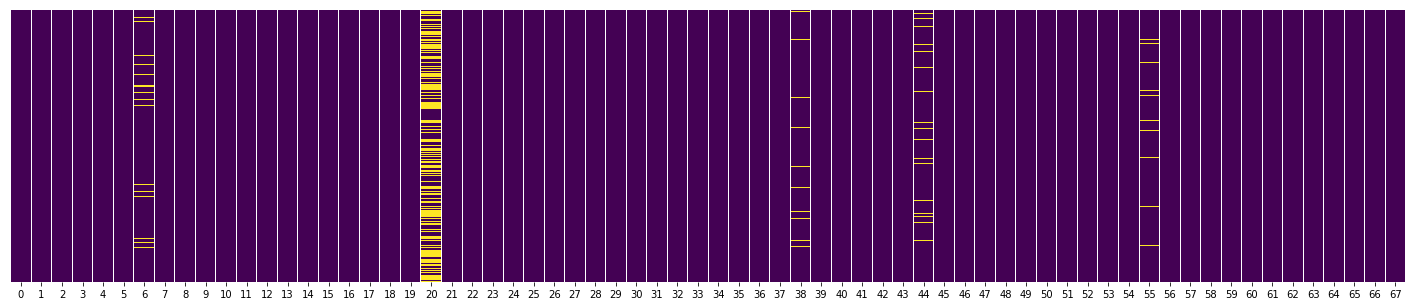

In [14]:
plt.figure(figsize=(25,5)) 
sns.set_context(font_scale=10)   
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis',xticklabels=list(range(len(df.columns))))

In [15]:
df.isnull().sum()[df.isnull().sum()>0]

emp_title                  23874
title                        132
dti                            2
mths_since_last_delinq    203962
revol_util                   162
last_credit_pull_d             9
bc_open_to_buy              3963
bc_util                     4227
mo_sin_old_il_acct         12254
mths_since_recent_bc        3798
mths_since_recent_inq      44599
num_rev_accts                  1
num_tl_120dpd_2m           19230
percent_bc_gt_75            4239
dtype: int64

In [146]:
# remove units
df.int_rate=df.int_rate.str[:-1]
df.term=df.term.str[:3]
# '<1 year'-->0, '10+ years'-->10
df.emp_length[df.emp_length=='< 1 year']=0
df.emp_length[df.emp_length=='10+ years']=10
df.emp_length[df.emp_length=='n/a']=np.nan
# bin loan titles with small count into Other
df.title[df.title.isin(df.title.value_counts()[df.title.value_counts()<100].index.tolist())==True]='Other'
# transform grade and sub_grade into ordinal numbers
#grade=df.grade.value_counts().index.sort_values().tolist()
#for i in range(len(grade)):
#    df.grade[df.grade==grade[i]]=i
#s_grade=df.sub_grade.value_counts().index.sort_values().tolist()
#for i in range(len(s_grade)):
#    df.sub_grade[df.sub_grade==s_grade[i]]=np.floor(i/5)+np.mod(i,5)/10*2
# Current,Fully Paid-->not default(0), -->default(1)

In [236]:
# good loans 
df.loan_status.value_counts()

Current               177845
Fully Paid            172354
Charged Off            60045
Late (31-120 days)      6130
In Grace Period         3227
Late (16-30 days)       1437
Default                   57
Name: loan_status, dtype: int64

In [17]:
df.purpose.value_counts()

debt_consolidation    250020
credit_card           102025
home_improvement       25293
other                  19204
major_purchase          7449
medical                 3938
car                     3466
small_business          3364
moving                  2420
vacation                2249
house                   1438
renewable_energy         224
wedding                    4
educational                1
Name: purpose, dtype: int64

In [16]:
df.columns.tolist()

['loan_amnt',
 'term',
 'int_rate',
 'installment',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'loan_status',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'earliest_cr_line',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'initial_list_status',
 'last_credit_pull_d',
 'application_type',
 'acc_now_delinq',
 'tot_coll_amt',
 'tot_cur_bal',
 'total_rev_hi_lim',
 'acc_open_past_24mths',
 'avg_cur_bal',
 'bc_open_to_buy',
 'bc_util',
 'chargeoff_within_12_mths',
 'mo_sin_old_il_acct',
 'mo_sin_old_rev_tl_op',
 'mo_sin_rcnt_rev_tl_op',
 'mo_sin_rcnt_tl',
 'mort_acc',
 'mths_since_recent_bc',
 'mths_since_recent_inq',
 'num_accts_ever_120_pd',
 'num_actv_bc_tl',
 'num_actv_rev_tl',
 'num_bc_sats',
 'num_bc_tl',
 'num_il_tl',
 'num_op_rev_tl',
 'num_rev_accts',
 'num_rev_tl_bal_gt_0',
 'num_sats',
 'num_tl_120dpd_2m',
 'num_tl_3

In [34]:
dff.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,...,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag
1,23100,23100,23100,60,20.50%,618.46,E,E4,Regional Sales Direcdtor,2 years,...,85.7,0,0,102524,55048,21700,80824,N,Cash,N
2,24250,24250,24250,60,24.24%,701.01,F,F3,hvac technician,4 years,...,63.6,0,0,344960,38475,29100,18300,N,Cash,N
22,16000,16000,16000,60,13.44%,367.67,C,C3,Merchandise Manager,1 year,...,30.8,0,0,87509,83690,23900,61109,N,Cash,N
38,27300,27300,27300,36,17.27%,977,D,D3,groundsman,10+ years,...,85.7,0,0,253900,60982,32000,37192,N,Cash,N
40,10000,10000,10000,60,17.97%,253.78,D,D4,Educator,2 years,...,100,0,0,302401,71518,11000,34953,N,Cash,N


In [95]:
dff1=pd.read_excel('LCDataDictionary.xlsx',sheetname='LoanStats')
dff2=pd.read_excel('LCDataDictionary.xlsx',sheetname='browseNotes')

In [126]:
dff1.LoanStatNew=dff1.LoanStatNew.str.strip()
dff2.BrowseNotesFile=dff2.BrowseNotesFile.str.strip()

In [127]:
for i in delete_col:
    if i not in dff1['LoanStatNew'].values:
        if i not in dff2['BrowseNotesFile'].values:
            

verification_status_joint


In [128]:
df.columns.tolist() 

ValueError: Arrays were different lengths: 145 vs 57

In [91]:
dfff.iloc[-3]

LoanStatNew                                      settlement_term
Description    The number of months that the borrower will be...
Name: 150, dtype: object

In [57]:
ind_keep=[]
ind_del=[]
for i in range(len(dff)):
    if dff.iloc[i,0] in delete_col:
        ind_del.append(i)
    else:
        ind_keep.append(i)

In [59]:
len(ind_del)

46

In [60]:
len(ind_keep)

107

In [69]:
dff.iloc[ind_del].to_csv('LendingClub_dict_del.csv',index=False)
dff.iloc[ind_keep].to_csv('LendingClub_dict_keep.csv',index=False)